## Краевая задача для ОДУ 2-го порядка

Вариант 18

$$ xy'' - (x+1)y' - 2(x-1)y = 0 \\ 
y'(0) = 4, \\ 
y'(1) - 2y(1) = - 9e^{-1} $$


Точное решение: 

$$ y(x) = e^{2x} + (3x+1)e^{-x} $$

### Конечно-разностный метод

В этой задаче: 
$$p(x) = (x+1), q(x) = 2(x-1), f(x) = 0, N = 10$$

Аппроксимируем граничное условие 3-го рода $y'(1) - 2y(1) = -9e^{-1}$ следующим образом:

$$ \frac{y_{n} - y_{n-1}}{h} - 2y_{n} = -9e^{-1} $$

а граничное условие 2-го рода $y'(0) = 4$ следующим:

$$\frac{y_{1} - y_{0}}{h} = 4 $$

In [1]:
import numpy as np 
px = lambda x: x+1
qx = lambda x: 2*(x-1)

Используем функцию решения трёхдиагональной СЛАУ из 1-ой лабораторной.

In [2]:
def progonka(A, d):
    N = A.shape[0]
    A1 = A.copy()
    x = np.zeros(N)
    Q = np.zeros(N)
    P = np.zeros(N)
    P[0] = -(A1[0, 1])/(A1[0, 0]) #прямой ход: вычисляем прогоночные коэффициенты
    Q[0] = d[0] / A1[0, 0] #отдельно для первого и последнего уравнений, циклом для всех остальных
    for i in range(1, N-1):
        P[i] = - (A1[i, i+1]) / (A1[i, i] + A1[i, i-1] * P[i-1]) 
        Q[i] = (d[i] - A1[i, i-1] * Q[i-1]) / (A1[i, i] + A1[i, i-1] * P[i-1])
    P[-1] = 0
    Q[-1] = (d[-1] - A1[-1, -2] * Q[-2]) / (A1[-1, -1] + A1[-1, -2] * P[-2])
    #print("P: ", P)
    #print("Q: ", Q)
    
    x[N-1] = Q[N-1] #обратный ход, вычисляем переменные начиная с последнего уравнения (его считаем отдельно)
    for j in range(N-2, -1, -1): 
        x[j] = P[j] * x[j+1] + Q[j]
    return x

In [3]:
def findiff_solve(p, q, fx, a, b, h):
    
    num_steps = int((b-a)/h)
    x = np.arange(a, b+h, h)
    y = np.empty(num_steps+1)
    N = y.shape[0]-1
    
    A12 = (1/h)
    A13 = -(1/h)
    b1 = 4
    An1 = -(1/h)
    An2 = (1/h) - 2
    bn = -9*np.exp(-1)
                                 
    A = np.zeros((y.shape[0], y.shape[0]))
    A[0][0] = A12
    A[0][1] = A13
    A[N][N-1] = An1
    A[N][N] = An2
    for k in range(1, N):
        A[k][k-1] = (1 - 0.5*(p(x[k])*h))
        A[k][k] = (-2 + (h**2)*q(x[k]))
        A[k][k+1] = (1 + 0.5*(p(x[k])*h))
    b = np.zeros(y.shape[0])
    b[0] = b1
    b[N] = bn
    y = progonka(A, b)
    return x, y
    
                          
    

In [4]:
x1, y1 = findiff_solve(px, qx, 0, 0, 1, 0.01)

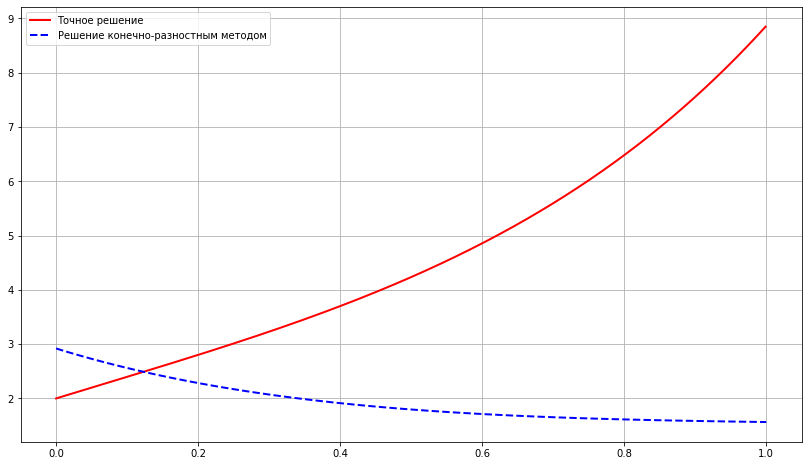

In [5]:
import matplotlib.pyplot as plt

true_func = lambda x: np.exp(2*x) + (3*x + 1)*np.exp(-x)
x_arr = np.arange(0, 1, 0.001)
true_arr = [true_func(xi) for xi in x_arr]

fig, ax = plt.subplots(figsize = [14,8])
ax.plot(x_arr, true_arr, 'r-', lw = 2, label = 'Точное решение')
ax.plot(x1, y1, 'b--', lw = 2, label = 'Решение конечно-разностным методом')
plt.legend(loc='best')
plt.grid(True)


### Метод стрельбы

$$ xy'' - (x+1)y' - 2(x-1)y = 0 \\ 
y'(0) = 4, \\ 
y'(1) - 2y(1) = - 9e^{-1} $$


Введём замену переменных и сведём исходную задачу к системе дифф. уравнений первого порядка: 
$$ 
\begin{equation}
    \begin{cases}
      y' = w \\ 
      w' = \frac{(x+1)w + 2(x-1)y}{x}
    \end{cases}\,.
\end{equation}
\\ w(0) = 4 \\ w(1) = -9e^{-1} + 2y(1)
$$

Вместо исходной задачи сформулируем задачу Коши с начальными условиями:
$$
w(0) = 4 \\
w'(0) = -9e^{-1} + 2y(1) 
$$

In [6]:
func = lambda x, y, w: ((x+1)*w + 2*(x-1)*y)/(x)
yb = lambda y1: -9*np.exp(-1) + 2*y1


Используем метод Рунге-Кутты 4 порядка точности. 

In [58]:
def RK_solve_4(func, y0, w0, h, a, b, eps):
    
    a1 = 0; a2 = 0.5; a3 = 0.5; a4 = 1 #коэфициенты для 4 порядка точности
    b21 = 0.5; b31 = 0; b32 = 0.5; 
    b41 = 0; b42 = 0; b43 = 0.5
    c1 = 1/6; c2 = 1/3; c3 = 1/3; c3 = 1/6
    num_steps = int((b-a)/h)
    tt = np.arange(a, b+h, h) #сам отрезок х
    y = np.zeros(num_steps+1)
    w = np.zeros(num_steps+1)
    y[0] = y0
    w[0] = w0
    for k in range(num_steps):
        Kk1 = h*func(tt[k], y[k], w[k]) #сами формулы Рунге-Кутты
        Lk1 = h*w[k]
        Kk2 = h*func(tt[k] + 0.5*h, y[k] + 0.5*Kk1, w[k] + 0.5*Lk1)
        Lk2 = h*(w[k] + 0.5*Lk1)
        Kk3 = h*func(tt[k] + 0.5*h, y[k] + 0.5*Kk2, w[k] + 0.5*Lk2 )
        Lk3 = h*(w[k] + 0.5*Lk2)
        Kk4 = h*func(tt[k] + h, y[k] + Kk3, w[k] + Lk3)
        Lk4 = h*(w[k] + Lk3)
        dyk = (1/6)*(Kk1 + 2*Kk2 + 2*Kk3 + Kk4)
        dwk = (1/6)*(Lk1 + 2*Lk2 + 2*Lk3 + Lk4)
        #print(dyk)
            
        y[k+1] = y[k] + dyk
        w[k+1] = w[k] + dwk
    return tt, y, w

In [61]:
def euler_solve(func, w0, h, a, b, eps):
    num_steps = int((b-a)/h)
    w = np.full(num_steps+1, np.inf)
    tt = np.arange(a, b+h, h) #сам отрезок х
    w[0] = w0
    for k in range(num_steps):
        w[k+1] = w[k] + h*func(tt[k], y[k], w[k])
        
    return tt, w

In [62]:
def shoot(th0, th1, func, y0, yb, h, a, b, eps):
    print('a')
    tt1, w1 = euler_solve(func, y0, h, a, b, 1e-2) #подставляем theta0 вместо w'(0)
    print('a')
    tt2, w2 = euler_solve(func, y0, th1, h, a, b, 1e-2) #подставляем theta1 вместо w'(0)
    print('a')
    print(y1)
    yt0 = y1[-1]
    yt1 = y2[-1]
    th_prev = th1
    th_2prev = th0
    phi_prev = yt1 - yb(yt1)
    phi_2prev = yt0 - yb(yt0)
    print(phi_prev)
    while True:
        th_n = th_prev - ((th_prev - th_2prev)/(phi_prev - phi_2prev))*phi_prev
        tt, w = euler_solve(func, y0, th_n, h, a, b, 1e-2)
        th_2prev = th_prev
        th_prev = th_n
        phi_2prev = phi_prev
        phi_prev = y[-1] - yb(y[-1])
        #print(phi_prev)
        if (phi_prev <= eps):
            break
    return tt, y, w
    
    
    

In [63]:
th0 = 1.0
th1 = 0.8
h = 0.1
a = 0; b = 1
eps = 1e-3

tt, y, w = shoot(th0, th1, func, 4, yb, h, a, b, eps)

a


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


KeyboardInterrupt: 

NameError: name 'tt' is not defined

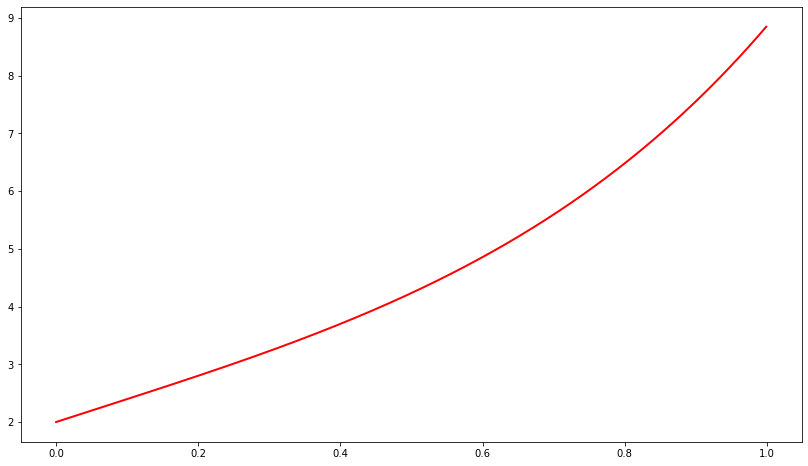

In [34]:
fig, ax = plt.subplots(figsize = [14,8])
ax.plot(x_arr, true_arr, 'r-', lw = 2, label = 'Точное решение')
ax.plot(tt, y, 'b--', lw = 2, label = "Для y Методом стрельбы")
ax.plot(tt, w, 'm--', lw = 2, label = "Для w Методом стрельбы")
plt.legend(loc='best')
plt.grid(True)
plt.ylim([0,5])